In [4]:
from optical_flow.flow_frames import *
from optical_flow.contrast import *
import pickle
import pandas as pd

# Superimposing Optical Flow Fields On Image Frames

In [ ]:
folder_path = '/Users/bradturow/Desktop/TDA/MPI-Sintel-complete/training'
image_paths = get_sintel_scene_folders(folder_path, scene_type='clean', scene='all')
flow_paths = get_sintel_scene_folders(folder_path, scene_type='flow', scene='all')

save_path = '/Users/bradturow/Desktop/Diagrams/Paper Diagrams/Optical Flow Paper Diagrams/Labeled Frames/'
j = 0
annotate_optical_flow(image_paths[j], flow_paths[j], save_path, 
                                lattice_res=(20, 30), scale=1.5, width = 0.001)


# Exploring Contrast Norm

In [5]:
#Load a large sample of raw optical flow patches from the Sintel dataset
with open('/Users/bradturow/optical_flow_sample_4000_pf.pickle', 'rb') as f:
    [patch_df, frame_paths] = pickle.load(f)

#Compute contrast norms 
print('computing contrast norms...')
patches = np.vstack(patch_df['patch'])
cnorms = get_contrast_norms(patches)   
patch_df['cnorm'] = cnorms
print('done.')

computing contrast norms...
done.


In [6]:
#Look at the distribution of contrast norm across the dataset
epsilon = 10**-6
log_norms = np.log(cnorms + epsilon)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax1, ax2 = axes

# -------------------------
# Left: Histogram + percentiles
# -------------------------

ax1.hist(log_norms, bins=30, density=True, color='skyblue', alpha=0.7)

percentiles = [80, 90, 95, 99]
percentile_values = np.percentile(log_norms, percentiles)

for p, v in zip(percentiles, percentile_values):
    ax1.axvline(x=v, color='red', linestyle='--')
    ax1.text(v, ax1.get_ylim()[1]*0.9, f'{p}%', rotation=90, color='red',
             ha='right', va='top')

ax1.set_title('Distribution Of Log Contrast Norm')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')
ax1.grid(True)

# -------------------------
# Right: Percentile curve
# -------------------------

N = 20
percentiles2 = int(100/N) * (np.arange(N) + 1)
contrasts = np.percentile(log_norms, percentiles2)

ax2.plot(percentiles2, contrasts, marker='o', linestyle='-')
ax2.set_title('Percentiles of Log Contrast Norm')
ax2.set_xlabel('Percentile')
ax2.set_ylabel('Value')
ax2.grid(True)

# -------------------------
plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

In [ ]:
thresh = 0.1
ind = cnorms > 16.22
percent = np.round(np.sum(ind)/len(ind)*100,5)
print('fraction of data with contrast norm above threshold:', percent, '%')

ind = cnorms > 0.2221
percent = np.round(np.sum(ind)/len(ind)*100,5)
print('fraction of data with contrast norm above threshold:', percent, '%')

In [ ]:
#Construct a video with labeled patches
scene_num = 3
min_cnorm = 16.22
max_cnorm = 1000
cnorm_ranges = [[0.2221,1000],[16.22,1000]]
directory = '/Volumes/Brad_Drive/Labeled_Videos/'

get_cnorm_video(frame_paths, scene_num, patch_df, cnorm_ranges, directory = directory)

# Predominant Direction And Directional Strength 

In [12]:
#Open the large HC20 sample
with open('/Users/bradturow/Desktop/Circle Bundle Code/HC20_Flow_Patches.pkl', 'rb') as f:
    patch_df = pickle.load(f)

filts = [[1500, 0.3], [1500, 0.5], [50, 0.6]]

#Get all the filtrations of HC20 used for the paper
dir_dict = {}

    
for filt in filts:
    
    #Get the data in X(k,p)
    k, p = filt
    column = 'density_' + str(k)
    patch_df = patch_df.sort_values(by = column, ascending = False)
    N = int(p*len(patch_df))
    dataset = np.vstack(patch_df['patch'])[:N]
    
    #Compute the base angle and directionality for each patch
    dir_dict[(k,p)] = {}
    dir_dict[(k,p)]['data'] = dataset
    dir_dict[(k, p)]['predom_dirs'], dir_dict[(k, p)]['directionality'] = get_predominant_dirs(dataset)
    dir_dict[(k,p)]['norms'] = np.array(patch_df['norm'])[:N]
    dir_dict[(k,p)]['title'] = f'K({k},{int(100*p)})'
    

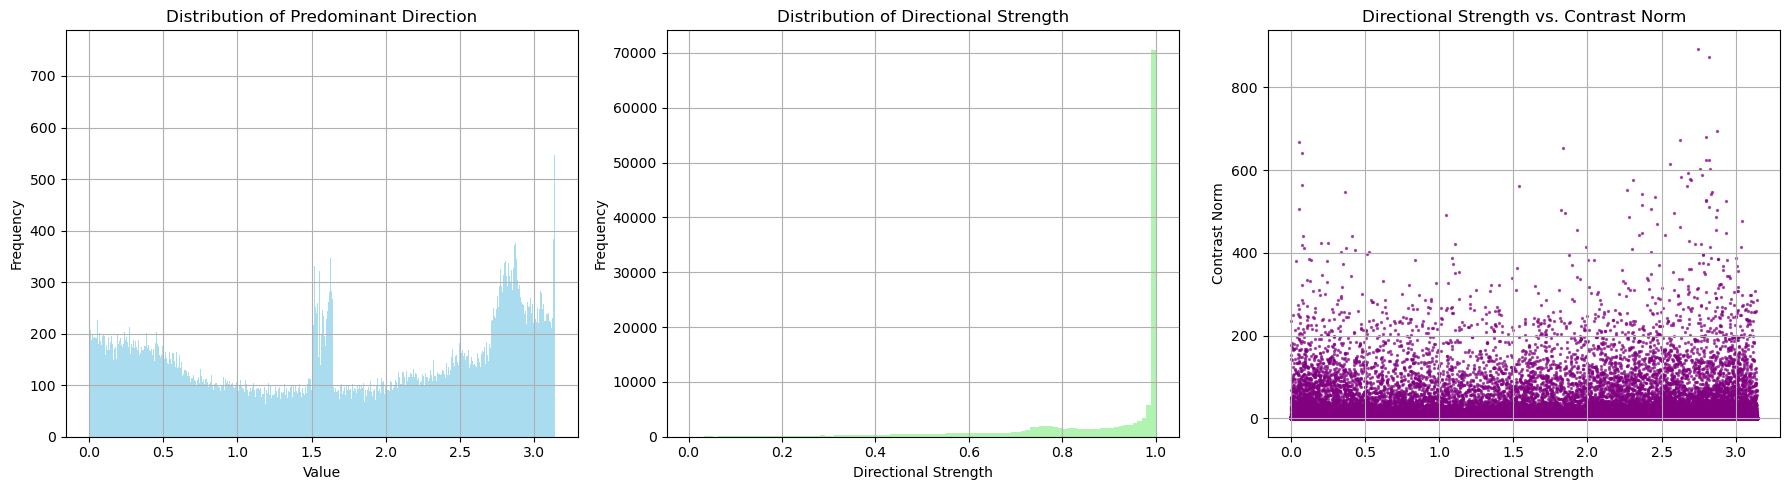

In [13]:
# Show the distributions of predominant direction, directional strength and contrast norm
j = 2  # Choose a dataset

k = filts[j][0]
p = filts[j][1]

# Create figure with 3 side-by-side subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ax1, ax2, ax3 = axes

# -------------------------
# 1. Predominant Direction Histogram
# -------------------------
ax1.hist(dir_dict[(k,p)]['predom_dirs'], bins=1000, color='skyblue', alpha=0.7)
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Predominant Direction')
ax1.grid(True)

# -------------------------
# 2. Directional Strength Histogram
# -------------------------
ax2.hist(dir_dict[(k,p)]['directionality'], bins=100, color='lightgreen', alpha=0.7)
ax2.set_xlabel('Directional Strength')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Directional Strength')
ax2.grid(True)

# -------------------------
# 3. Scatter Plot: Ratio vs Norm
# -------------------------
ax3.scatter(dir_dict[(k,p)]['predom_dirs'], dir_dict[(k,p)]['norms'], s=2, alpha=0.6, color='purple')
ax3.set_xlabel('Directional Strength')
ax3.set_ylabel('Contrast Norm')
ax3.set_title('Directional Strength vs. Contrast Norm')
ax3.grid(True)

# -------------------------
plt.tight_layout()
plt.show()


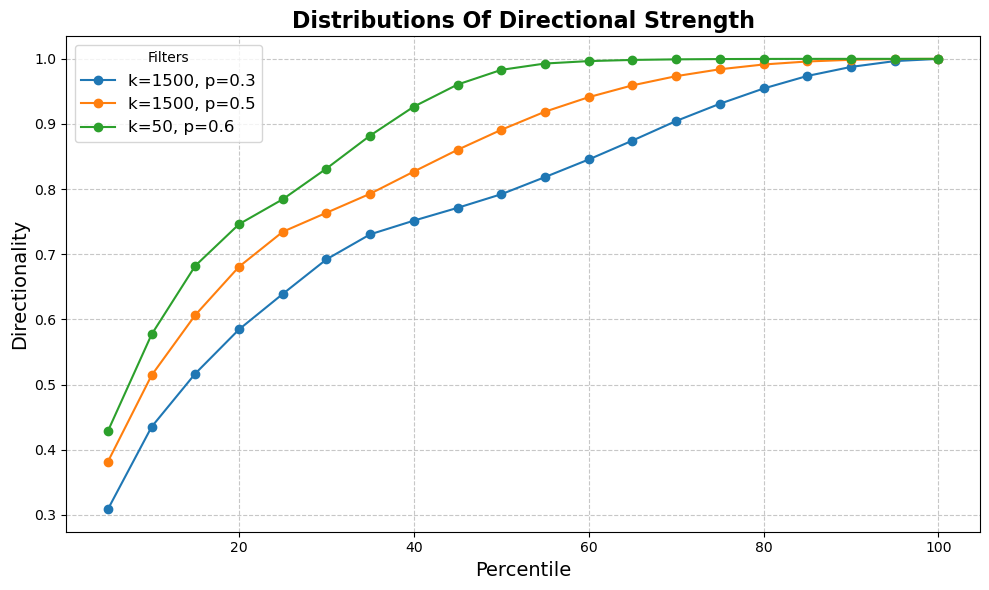

In [15]:
#Compare the distributions of directional strength across the datasets

# Parameters
C = 5  # Step size for percentiles
percentiles = np.arange(C, 101, C)  # Percentiles from 5% to 100%

# Initialize a figure
plt.figure(figsize=(10, 6))

# Loop through each (k, p) in dir_dict and plot the values directly
for key, data in dir_dict.items():
    k, p = key
    if k != 100:
        # Compute taus from directionality
#        taus = np.arccos(np.clip((2 - data['directionality']) ** (-0.5), -1, 1))
        dir_strength = data['directionality']    
        # Compute the values at specified percentiles
        values = np.percentile(dir_strength, percentiles)

        # Plot the percentile values for this (k, p) pair
        label = f'k={k}, p={p}'
        plt.plot(percentiles, values, label=label, marker='o')  # Plot with markers

# Set plot labels and title
plt.xlabel('Percentile', fontsize=14)
plt.ylabel(r'Directionality', fontsize=14)
plt.title(r'Distributions Of Directional Strength', fontsize=16, weight='bold')

# Add a legend
plt.legend(title='Filters', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
#plt.savefig('/Users/bradturow/Desktop/TDA/Optical Flow Project/Paper Diagrams/Distributions_Of_Directionality.pdf', format='pdf', bbox_inches='tight')
plt.show()


